<a href="https://colab.research.google.com/github/ABDELHALIM9/deep-learing-project/blob/main/dense_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
from pathlib import Path
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import os
import shutil
from collections import Counter

# Select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir("/kaggle/input")

There are 1 directories and 0 images in '/kaggle/input'.
There are 1 directories and 0 images in '/kaggle/input/chest-xray-pneumonia'.
There are 5 directories and 0 images in '/kaggle/input/chest-xray-pneumonia/chest_xray'.
There are 3 directories and 1 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'.
There are 2 directories and 1 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'.
There are 0 directories and 9 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL'.
There are 2 directories and 1 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'.
There are 0 directories and 390 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL'.
There are 2

In [8]:
!ls /kaggle/input

chest-xray-pneumonia


In [9]:
data_path = Path("/kaggle/input/chest-xray-pneumonia")
image_path = data_path / "chest_xray"
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"


# redistribute the data

In [10]:
# Combine all data into a single list
data = []
labels = []

# Helper function to load data from directories
def load_data_from_directory(directory, label):
    for img_file in directory.glob("*.jpeg"):  
        data.append(str(img_file))  
        labels.append(label)

# Load images from all directories
load_data_from_directory(train_dir / "PNEUMONIA", "PNEUMONIA")
load_data_from_directory(train_dir / "NORMAL", "NORMAL")
load_data_from_directory(test_dir / "PNEUMONIA", "PNEUMONIA")
load_data_from_directory(test_dir / "NORMAL", "NORMAL")
load_data_from_directory(val_dir / "PNEUMONIA", "PNEUMONIA")
load_data_from_directory(val_dir / "NORMAL", "NORMAL")

# Convert labels to binary (0 for NORMAL, 1 for PNEUMONIA)
labels = [0 if label == "NORMAL" else 1 for label in labels]

# Print the number of samples per class before balancing
print("Number of samples per class before balancing:")
print(Counter(labels))



# Count the number of samples in each class
label_counts = Counter(labels)
min_count = min(label_counts.values())  # Minimum number of samples in any class

# Create balanced data and labels
balanced_data = []
balanced_labels = []

# Helper function to balance a class
def balance_class(data, labels, target_label, max_samples):
    class_data = [(d, l) for d, l in zip(data, labels) if l == target_label]
    class_data = shuffle(class_data, random_state=42)[:max_samples]
    return zip(*class_data)

# Balance each class
for target_label in label_counts.keys():
    class_data, class_labels = balance_class(data, labels, target_label, min_count)
    balanced_data.extend(class_data)
    balanced_labels.extend(class_labels)

# Shuffle the balanced dataset
balanced_data, balanced_labels = shuffle(balanced_data, balanced_labels, random_state=42)

# Print the number of samples per class after balancing
print("Number of samples per class after balancing:")
print(Counter(balanced_labels))

# Split the data into new train, val, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    balanced_data, balanced_labels, test_size=0.15, random_state=42, stratify=balanced_labels)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.15, random_state=42, stratify=train_labels)

# Print the number of data points in train, validation, and test sets
print(f"Number of samples in Train set: {len(train_data)}")
print(f"Number of samples in Validation set: {len(val_data)}")
print(f"Number of samples in Test set: {len(test_data)}")

# New directories for reorganized dataset
working_dir = Path("/kaggle/working/reorganized_dataset")
new_train_dir = working_dir / "train"
new_val_dir = working_dir / "val"
new_test_dir = working_dir / "test"

for sub_dir in ["PNEUMONIA", "NORMAL"]:
    (new_train_dir / sub_dir).mkdir(parents=True, exist_ok=True)
    (new_val_dir / sub_dir).mkdir(parents=True, exist_ok=True)
    (new_test_dir / sub_dir).mkdir(parents=True, exist_ok=True)

# Helper function to copy files to new directories
def copy_files(data, labels, output_dir):
    for img_path, label in zip(data, labels):
        label_dir = "PNEUMONIA" if label == 1 else "NORMAL"
        shutil.copy(img_path, output_dir / label_dir)

# Copy the images to the respective directories
copy_files(train_data, train_labels, new_train_dir)
copy_files(val_data, val_labels, new_val_dir)
copy_files(test_data, test_labels, new_test_dir)

print("Balanced dataset has been reorganized!")
print(f"New Train directory: {new_train_dir}")
print(f"New Validation directory: {new_val_dir}")
print(f"New Test directory: {new_test_dir}")


Number of samples per class before balancing:
Counter({1: 4273, 0: 1583})
Number of samples per class after balancing:
Counter({1: 1583, 0: 1583})
Number of samples in Train set: 2287
Number of samples in Validation set: 404
Number of samples in Test set: 475
Balanced dataset has been reorganized!
New Train directory: /kaggle/working/reorganized_dataset/train
New Validation directory: /kaggle/working/reorganized_dataset/val
New Test directory: /kaggle/working/reorganized_dataset/test


**visualize dataset**

Random image path: /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0961-0001.jpeg
Image class: NORMAL
Image height: 1642
Image width: 1840


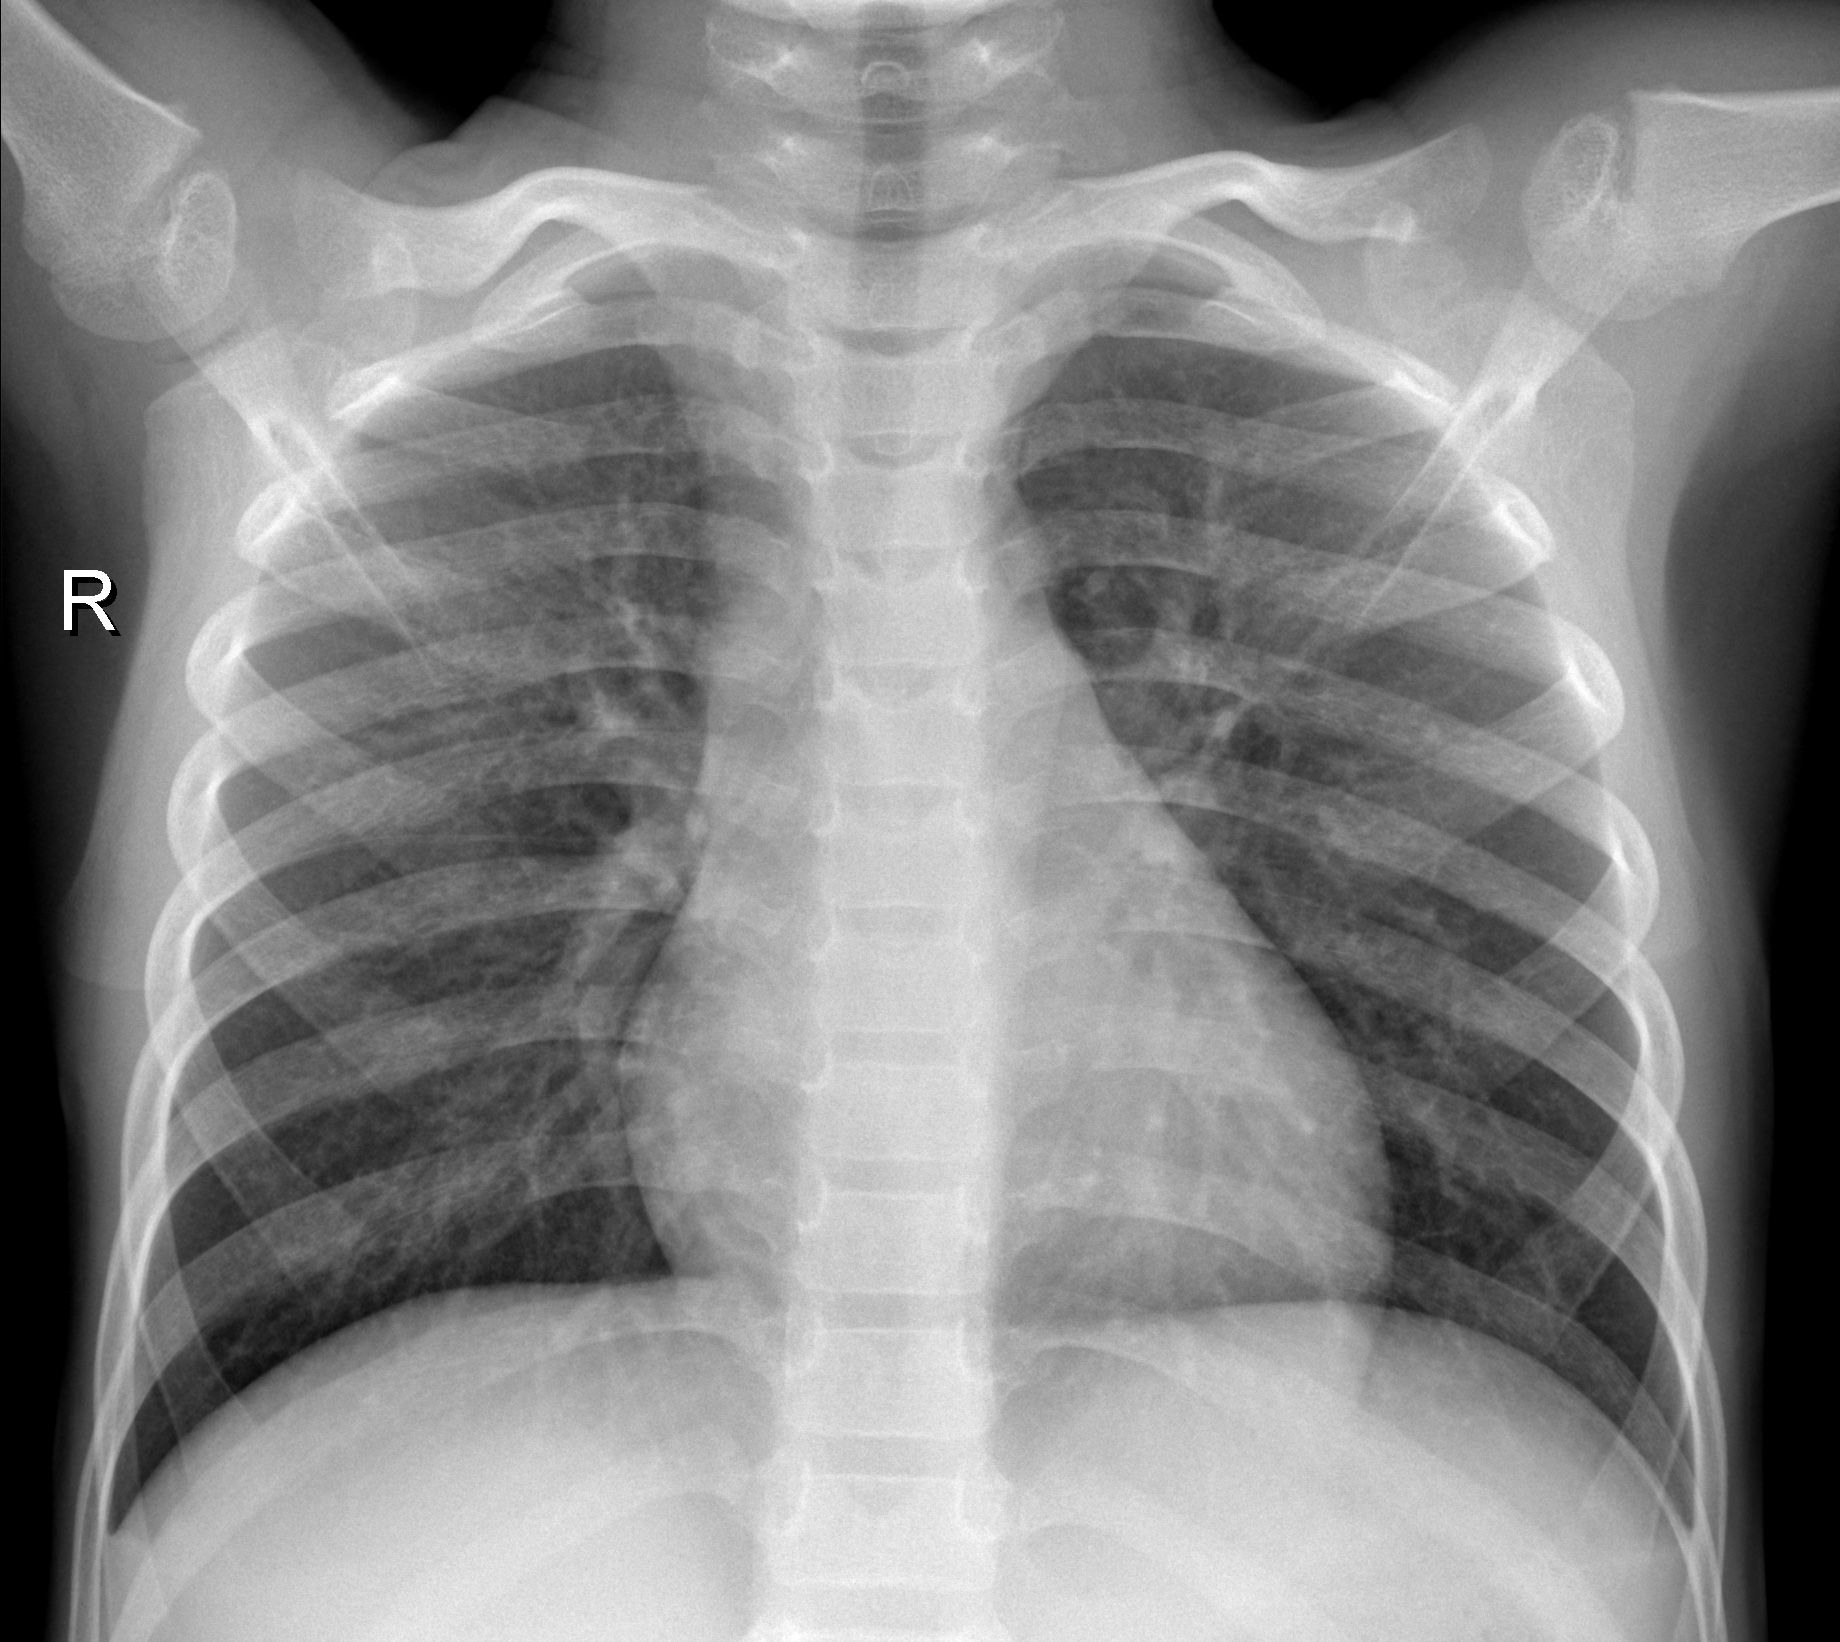

In [11]:


# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpeg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [12]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel (grayscale) to 3 channels
    transforms.Resize(256),  # Resize to 256 on the smaller edge
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
])

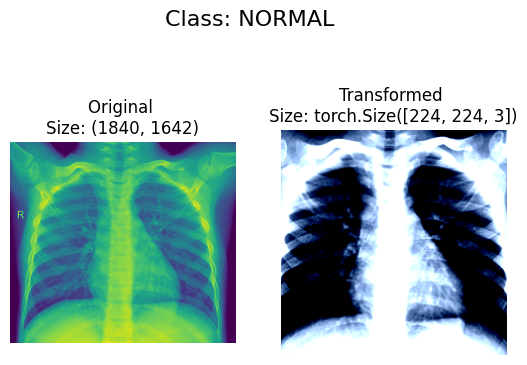

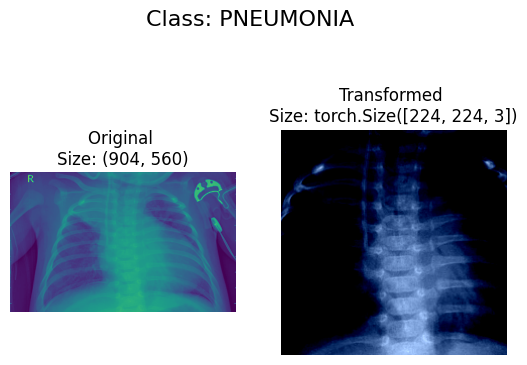

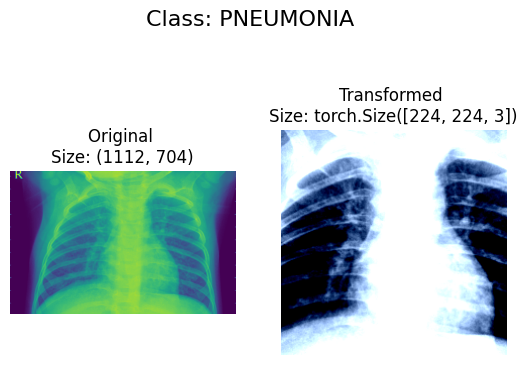

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
            img = Image.open(image_path)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)



In [14]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=new_train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=new_test_dir,
                                 transform=data_transform)
val_data = datasets.ImageFolder(root=new_val_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}\nVal data:\n{val_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2287
    Root location: /kaggle/working/reorganized_dataset/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 475
    Root location: /kaggle/working/reorganized_dataset/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Val data:
Dataset ImageFolder
    Number of datapoints: 404
    Root location

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'NORMAL': 0, 'PNEUMONIA': 1}

In [17]:
# Check the lengths
len(train_data), len(test_data), len(val_data)

(2287, 475, 404)

In [18]:

# Count labels in the training data
train_label_counts = Counter(train_data.targets)
test_label_counts = Counter(test_data.targets)
val_label_counts = Counter(val_data.targets)

# Print the counts
class_names = {'NORMAL': 0, 'PNEUMONIA': 1}
for class_name, label in class_names.items():
    print(f"Training data - {class_name}: {train_label_counts[label]} images")
    print(f"Test data - {class_name}: {test_label_counts[label]} images")
    print(f"Validation data - {class_name}: {val_label_counts[label]} images")


Training data - NORMAL: 1143 images
Test data - NORMAL: 238 images
Validation data - NORMAL: 202 images
Training data - PNEUMONIA: 1144 images
Test data - PNEUMONIA: 237 images
Validation data - PNEUMONIA: 202 images


In [19]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.6734, 0.7419, 0.7591,  ..., 1.0331, 0.9988, 0.9132],
         [0.6734, 0.7591, 0.6906,  ..., 1.0673, 1.0331, 0.9988],
         [0.6734, 0.6563, 0.6392,  ..., 1.0844, 1.0673, 1.0673],
         ...,
         [1.1529, 1.1700, 1.2385,  ..., 1.2043, 1.1529, 1.1529],
         [1.1529, 1.2385, 1.2899,  ..., 1.2214, 1.1529, 1.1358],
         [1.1700, 1.2728, 1.2728,  ..., 1.1872, 1.1358, 1.1015]],

        [[0.8179, 0.8880, 0.9055,  ..., 1.1856, 1.1506, 1.0630],
         [0.8179, 0.9055, 0.8354,  ..., 1.2206, 1.1856, 1.1506],
         [0.8179, 0.8004, 0.7829,  ..., 1.2381, 1.2206, 1.2206],
         ...,
         [1.3081, 1.3256, 1.3957,  ..., 1.3606, 1.3081, 1.3081],
         [1.3081, 1.3957, 1.4482,  ..., 1.3782, 1.3081, 1.2906],
         [1.3256, 1.4307, 1.4307,  ..., 1.3431, 1.2906, 1.2556]],

        [[1.0365, 1.1062, 1.1237,  ..., 1.4025, 1.3677, 1.2805],
         [1.0365, 1.1237, 1.0539,  ..., 1.4374, 1.4025, 1.3677],
         [1.0365, 1.0191, 1.0017,  ..., 1.45

In [20]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, 
                              num_workers=1, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) 

val_dataloader = DataLoader(dataset=val_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78da2b97ff10>,
 <torch.utils.data.dataloader.DataLoader at 0x78da2b47cb50>)

In [21]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


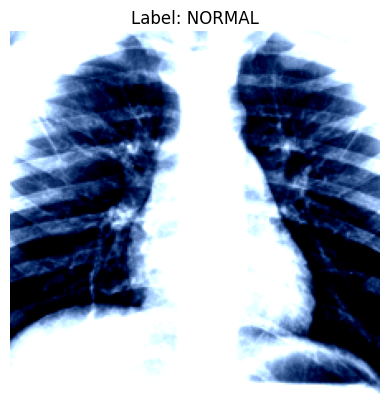

In [22]:
# Access the first image and its label from the training data
img, label = train_data[0]
# Display the image and its label
plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title(f"Label: {train_data.classes[label]}")  # Display class name using label index
plt.axis('off')  # Turn off axis
plt.show()


# calling the model

In [23]:


# Load DenseNet-121 with pretrained weights
weights = models.DenseNet121_Weights.DEFAULT  # Best available pretrained weights
model = models.densenet121(weights=weights).to(device)



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 164MB/s] 


In [24]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

# freezing the features

In [25]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

# adjust the ouput layer

In [26]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

# summary after

In [27]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

# defining the loss and the optimizer and class imbalance

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


# early stopping class


In [29]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after the last improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.wait = 0
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop = True

# plots for metrics


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support, classification_report

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_probs, num_classes):
    """Plots the ROC curve for binary or multiclass classification."""
    if num_classes == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc="lower right")
        plt.show()
    else:  # Multiclass classification
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Multiclass)")
        plt.legend(loc="lower right")
        plt.show()

def calculate_metrics(y_true, y_pred):
    """Calculates and prints precision, recall, and F1-score."""
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
    return precision, recall, f1

# training and testing loop

In [31]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch."""
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch."""
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:
    """Validates the model for a single epoch."""
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            y_pred_labels = y_pred.argmax(dim=1)
            val_acc += (y_pred_labels == y).sum().item() / len(y_pred_labels)
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          patience: int = 5,
          class_names: List[str] = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model."""
    results = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "test_loss": [], "test_acc": []
    }
    early_stopping = EarlyStopping(patience=patience)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        val_loss, val_acc = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
              f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        early_stopping(val_loss)
        if early_stopping.stop:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    # After training, calculate and plot metrics
    all_y_true, all_y_pred, all_y_probs = [], [], []
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_probs = torch.softmax(model(X), dim=1)
            y_pred = torch.argmax(y_probs, dim=1)
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(y_pred.cpu().numpy())
            all_y_probs.extend(y_probs.cpu().numpy())

    # Generate confusion matrix, ROC curve, and calculate metrics
    if class_names:
        plot_confusion_matrix(all_y_true, all_y_pred, class_names)

    num_classes = len(class_names)
    plot_roc_curve(all_y_true, np.array(all_y_probs), num_classes)
    calculate_metrics(all_y_true, all_y_pred)
    classification_report(all_y_true, all_y_pred)

    return results




In [35]:
    classification_report(all_y_true, all_y_pred)


NameError: name 'all_y_true' is not defined

# training the model

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3921 | train_acc: 0.8255 | val_loss: 0.2510 | val_acc: 0.9043 | test_loss: 0.2088 | test_acc: 0.9479
Epoch: 2 | train_loss: 0.2281 | train_acc: 0.9154 | val_loss: 0.2345 | val_acc: 0.9187 | test_loss: 0.1854 | test_acc: 0.9238
Epoch: 3 | train_loss: 0.2031 | train_acc: 0.9236 | val_loss: 0.2064 | val_acc: 0.9212 | test_loss: 0.1611 | test_acc: 0.9405
Epoch: 4 | train_loss: 0.1771 | train_acc: 0.9374 | val_loss: 0.1910 | val_acc: 0.9260 | test_loss: 0.1529 | test_acc: 0.9426
Epoch: 5 | train_loss: 0.1748 | train_acc: 0.9392 | val_loss: 0.1789 | val_acc: 0.9308 | test_loss: 0.1458 | test_acc: 0.9563
Epoch: 6 | train_loss: 0.1722 | train_acc: 0.9391 | val_loss: 0.1772 | val_acc: 0.9260 | test_loss: 0.1418 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.1759 | train_acc: 0.9361 | val_loss: 0.1718 | val_acc: 0.9332 | test_loss: 0.1391 | test_acc: 0.9555
Epoch: 8 | train_loss: 0.1660 | train_acc: 0.9407 | val_loss: 0.1936 | val_acc: 0.9356 | test_loss: 0.1554 | test_acc:

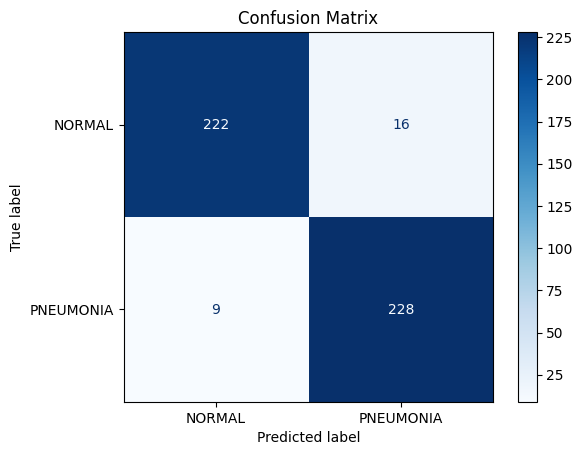

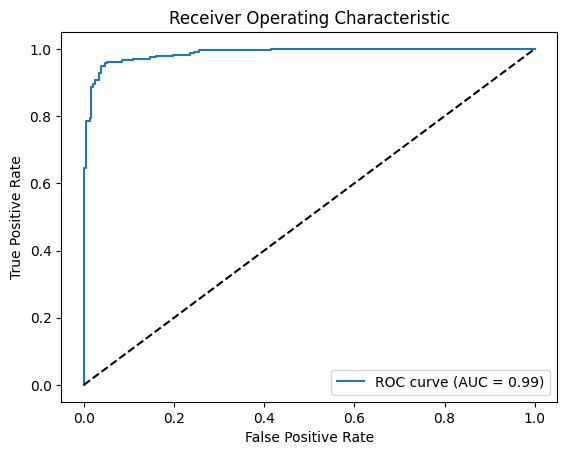

Precision: 0.95, Recall: 0.95, F1-score: 0.95
[INFO] Total training time: 2739.372 seconds


In [32]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50,
                device=device,
                patience=7,
                class_names=class_names)  # Stop training if no improvement for 7 epochs


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# evaluate

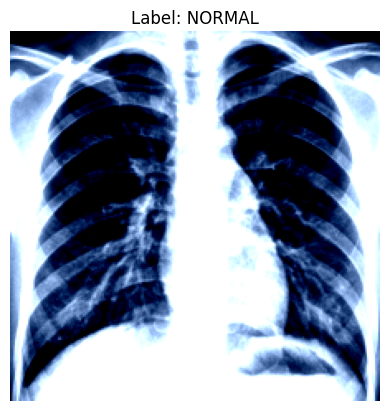

In [33]:
# Access the first image and its label from the training data
img, label = val_data[0]
# Display the image and its label
plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title(f"Label: {train_data.classes[label]}")  # Display class name using label index
plt.axis('off')  # Turn off axis
plt.show()


In [34]:
idx_to_class = {v: k for k, v in class_names.items()}  # {0: 'NORMAL', 1: 'PNEUMONIA'}

model.eval()
with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = img.unsqueeze(dim=0)
      # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model( transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Map index to class name
    predicted_class = idx_to_class[target_image_pred_label.item()]
    print(f"Predicted Class: {predicted_class}")

Predicted Class: NORMAL


In [36]:
def evaluate_model(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   device: torch.device,
                   class_names: List[str] = None):
    """Evaluates the model and prints the classification report."""
    model.eval()
    all_y_true, all_y_pred = [], []
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X).argmax(dim=1)  # Get predicted class labels
            all_y_true.extend(y.cpu().numpy())  # True labels
            all_y_pred.extend(y_pred.cpu().numpy())  # Predicted labels

    # Generate and print classification report
    print("Classification Report:")
    print(classification_report(all_y_true, all_y_pred, target_names=class_names))


evaluate_model(model, test_dataloader, device, class_names)


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.93      0.95       238
   PNEUMONIA       0.93      0.96      0.95       237

    accuracy                           0.95       475
   macro avg       0.95      0.95      0.95       475
weighted avg       0.95      0.95      0.95       475

